In [59]:
#My default packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from enum import Enum,IntEnum
import typing
from collections import defaultdict
from itertools import cycle

from dataclasses import dataclass
import itertools
import heapq


# Day 23

In [288]:
@dataclass
class Point:
    x: int
    y: int

    def __hash__(self) -> int:
        return hash((self.x, self.y))

    def __add__(self, other) -> "Point":
        return Point(self.x + other.x, self.y + other.y)

    def __sub__(self, other) -> "Point":
        return Point(self.x - other.x, self.y - other.y)

class Dir(IntEnum):
    N = 0
    NE = 1
    E = 2
    SE = 3
    S = 4
    SW = 5
    W = 6
    NW = 7

    @property
    def vec(self):
        listvec = [Point(0,1), Point(1,1), Point(1,0), Point(1,-1), Point(0,-1), Point(-1,-1), Point(-1,0), Point(-1,1)]
        return listvec[self.value]

PropositionRound = {Dir.N:Dir.S,Dir.S:Dir.W,Dir.W:Dir.E,Dir.E:Dir.N}

@dataclass
class Elf:
    pos : Point
    dir : Dir = Dir.N
    prev : Point = None

    def __repr__(self) -> str:
        return f"Elf({(self.pos.x,self.pos.y)},{self.dir.name})"

In [372]:
@dataclass
class ElfParty:
    elves : dict

    def __getitem__(self, key: typing.Union[Point, tuple]) -> typing.Union[Elf, None] :
        if isinstance(key, tuple):
            key = Point(*key)
        return self.elves.get(key, None)

    def __setitem__(self, key: typing.Union[Point, tuple], value: Elf):
        if isinstance(key, tuple):
            key = Point(*key)
        self.elves[key] = value

    @classmethod
    def frominput(cls,filename):
        elves = cls({})
        with open(filename) as f:
            for j,l in enumerate(f.read().splitlines()):
                for i,c in enumerate(l):
                    if c=="#":
                        elves[Point(i,-j)] = Elf(Point(i,-j))
        return elves

    def round(self):

        #First half
        proposedmoves = defaultdict(list)
        for pos,elf in self.elves.items():
            elf.prev = elf.pos
            neigh = [isinstance(self[pos+d.vec],Elf) for d in Dir]
            if any(neigh):
                dir = elf.dir
                for _ in range(4):
                    sl = [(dir+j)%8 for j in [-1,0,1]]
                    # print(sl,pos,all(neigh[s] for s in sl),sum(neigh))
                    if not any(neigh[s] for s in sl):
                        proposedmoves[pos+dir.vec].append(elf)
                        break
                    dir = PropositionRound[dir]
            elf.dir = PropositionRound[elf.dir]

        #Second half
        for pos,candidates in proposedmoves.items():

            if len(candidates)==1:
                elf = candidates[0]
                elf = self.elves.pop(elf.pos)
                elf.pos = pos
                self[pos] = elf

        return proposedmoves

    def neighbours(self,elf):
        
        neigh = [self[elf.pos+d.vec] for d in Dir]
        return neigh

    def dims(self):
        ini =False
        for pos in self.elves.keys():
            if not ini:
                xmin,xmax = (pos.x,pos.x)
                ymin,ymax = (pos.y,pos.y)
                ini=True
            xmin = min(xmin,pos.x)
            xmax = max(xmax,pos.x)
            ymin = min(ymin,pos.y)
            ymax = max(ymax,pos.y)
        return xmin,xmax,ymin,ymax

    def freespace(self):
        xmin,xmax,ymin,ymax = self.dims()
        nelves = len(self.elves)
        return (xmax-xmin+1)*(ymax-ymin+1)-nelves

    def finalstate(self):
        for pos,elf in self.elves.items():
            if elf.pos!=elf.prev:
                return False
        return True
    
    def centerofmass(self):
        N = len(self.elves)
        com = Point(0,0)
        for pos in self.elves:
            com+=pos
        return (com.x/N,com.y/N)
    def toarray(self):
        xmin,xmax,ymin,ymax = self.dims()
        arr = np.zeros(((ymax-ymin+3),(xmax-xmin+3)),dtype=int)
        for pos in self.elves:
            arr[pos.y-ymin+1,pos.x-xmin+1]=1
        return arr
    def toascii(self):
        xmin,xmax,ymin,ymax = self.dims()
        art = []
        for y in range(ymax,ymin-1,-1):
            art.append("".join("#" if self[(x,y)] is not None else "." for x in range(xmin,xmax+1)))
        return "\n".join(art)

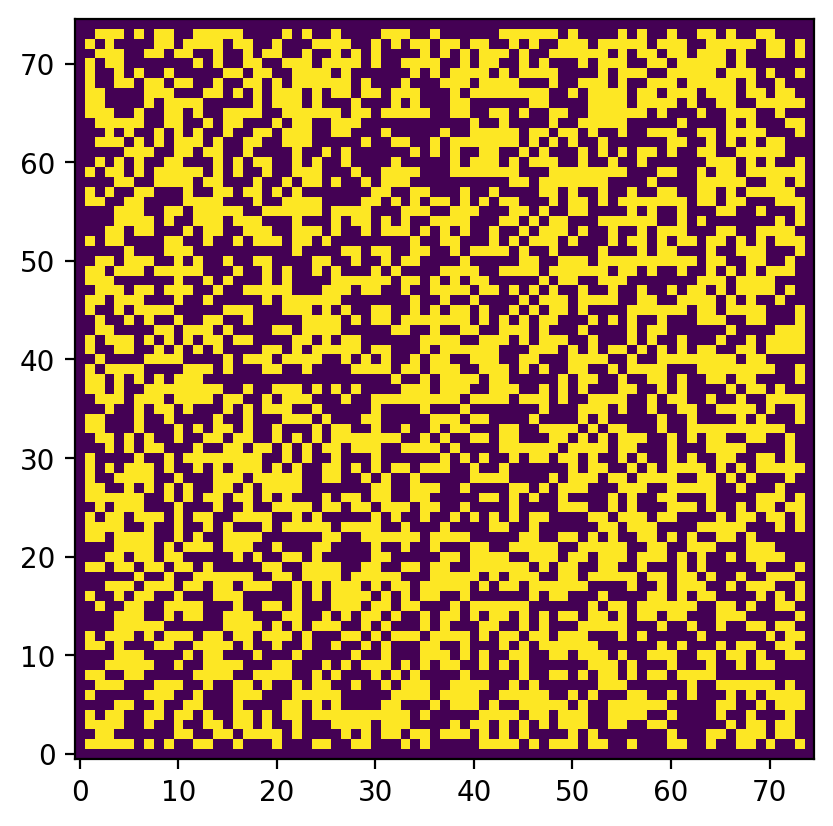

In [380]:
elves0 = ElfParty.frominput("input23.txt")
elves.freespace(),elves.dims()
plt.imshow(elves0.toarray(),origin="lower")

4218 (-6, 77, -77, 4)


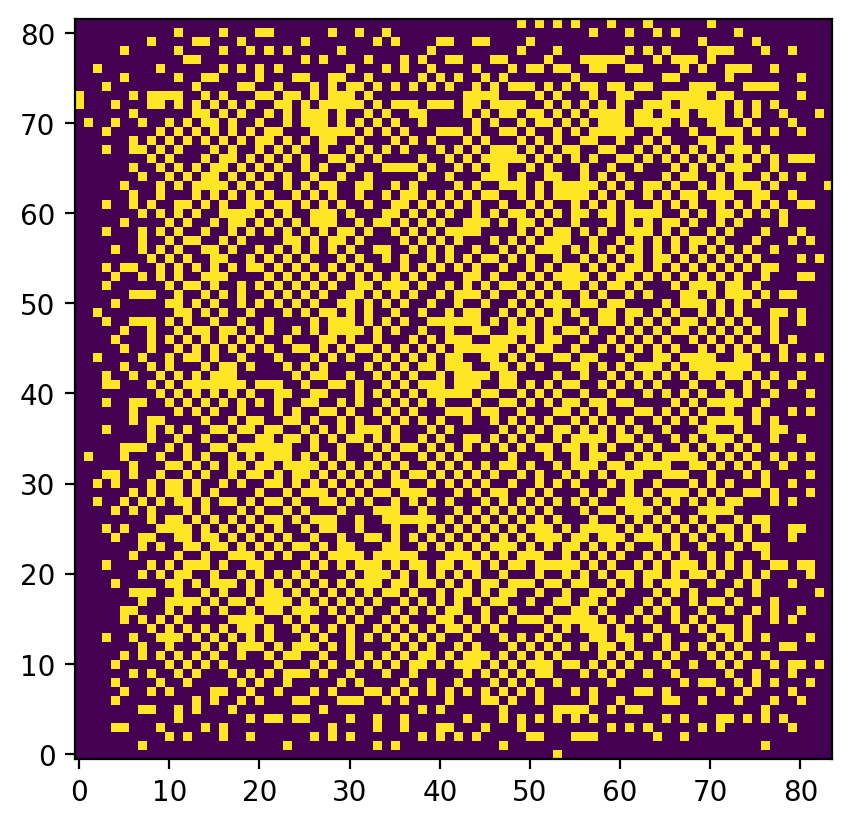

In [349]:
elves = ElfParty.frominput("input23.txt")

for k in range(10):
    elves.round()
print(elves.freespace(),elves.dims())
plt.imshow(elves.toarray(),origin="lower")

Total free space after 976 rounds : 16926


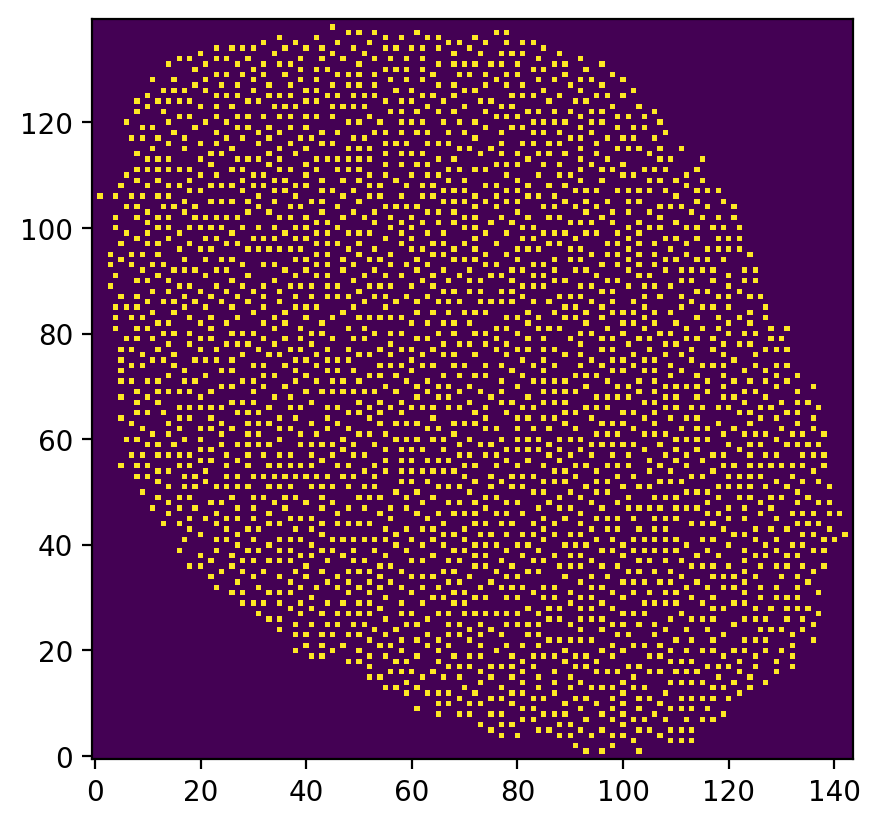

In [373]:
elves = ElfParty.frominput("input23.txt")
k=0
freespace = [elves.freespace()]
coms = [elves.centerofmass()]
while not elves.finalstate():
    elves.round()
    k+=1
    freespace.append(elves.freespace())
    coms.append(elves.centerofmass())
print(f"Total free space after {k} rounds : {elves.freespace()}")
plt.imshow(elves.toarray(),origin="lower")

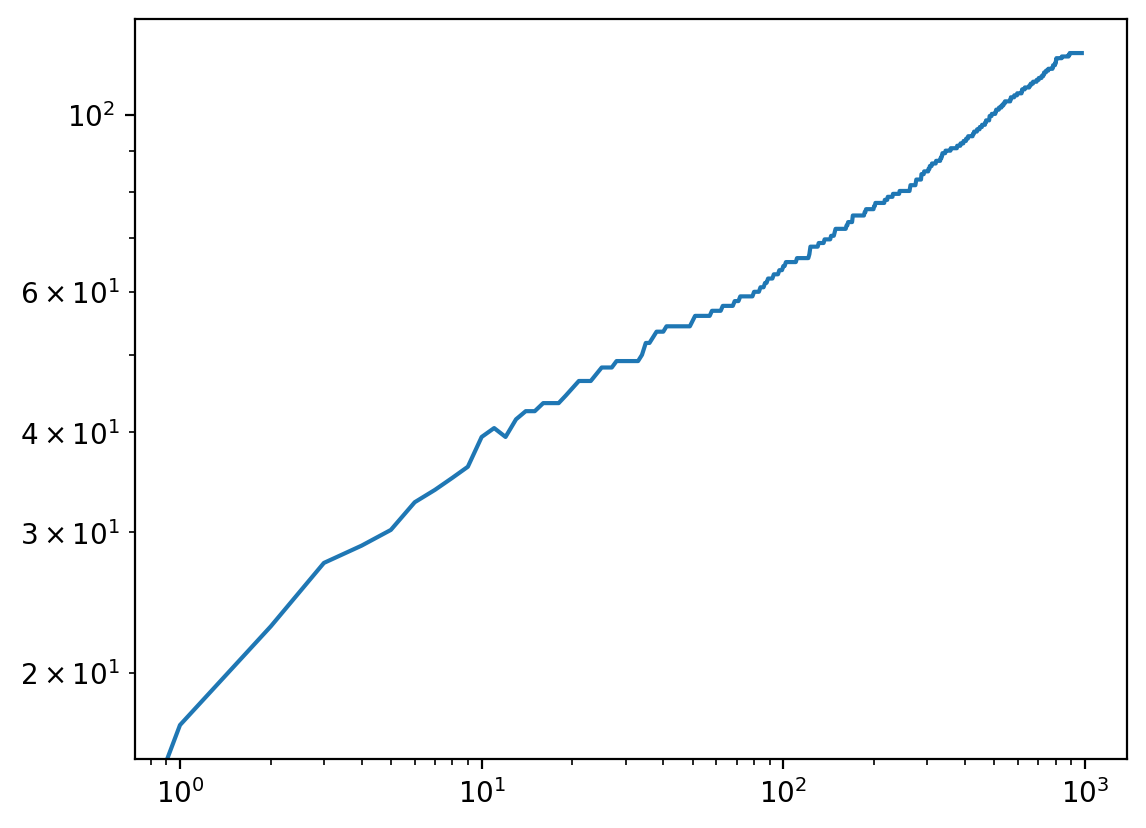

In [371]:
plt.loglog((np.array(freespace)-freespace[0])**.5)
